
# Project: MTA WMWY turnstile analysis

**Program:** mta_women_tech_gala_final_CCHAN.ipynb <br>
**Date:** Jan 8, 2021 <br>
**Desc:** Analyze MTA and Census data to make recommendations on where to deploy canvasers <br>
**Created by:** Josh Banks, Chuck Cao, Humza Khan, Chris Chan <br>
**Chris Chan specific code. See sections:** <br>
&emsp;&emsp;&emsp;&emsp;&emsp;**3:** adding income data to stations<br>
&emsp;&emsp;&emsp;&emsp;&emsp;**4:** merge stations/income to turnstile df<br>
&emsp;&emsp;&emsp;&emsp;&emsp;**6c:** graphs for high income stations<br>
&emsp;&emsp;&emsp;&emsp;&emsp;**7:** attemps to improve map
&emsp;&emsp;&emsp;&emsp;&emsp;**8:** testing code
<br>
<br>

## 1. Prep MTA Turnstile data
### This section was a combined effort of the whole team

In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
import seaborn as sb

In [2]:
#initialise the number of weeks for the dataset
num_weeks = 4

#initialise the date for the first week of the dataset (week ending on start_date)
start_date = filedate = pd.Timestamp('2019-06-29 00:00:00')

#initialise the regex for the MTA turnstile url
filename_regex = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    filename = filename_regex.format(filedate_str)

    # read the file and append it to the list of files to be concacated
    #df = pd.read_csv(filename, parse_dates=['DATE'], keep_date_col=True)  
    df = pd.read_csv(filename, keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

df = pd.concat(filelist, axis=0, ignore_index=True)

In [3]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [4]:
# rename columns since the last column, 'EXITS', contains trailing whitespace
df.columns = df.columns.str.replace(r'\s+', '')
df["EXITS"] = pd.to_numeric(df["EXITS"])
df["ENTRIES"] = pd.to_numeric(df["ENTRIES"])

In [5]:
df['Datetime'] = pd.to_datetime(df.DATE + df.TIME, format='%m/%d/%Y%H:%M:%S')

### Get counter-runs isolated

In [6]:
df['Traffic_running_total']=df['ENTRIES']+df['EXITS']

In [7]:
# creating DF: grouping by unique turnstile and date to remove dups
turnstiles_4hourly = (df.groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME","Datetime"],as_index=False)).Traffic_running_total.first()

In [8]:
turnstiles_4hourly.shape

(833292, 7)

In [9]:
turnstiles_4hourly.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total
0,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 00:00:00,9515182
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 04:00:00,9515203
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 08:00:00,9515252
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 12:00:00,9515399
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 16:00:00,9515656
5,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 20:00:00,9515941
6,A002,R051,02-00-00,59 ST,NQR456W,2019-06-23 00:00:00,9516110
7,A002,R051,02-00-00,59 ST,NQR456W,2019-06-23 04:00:00,9516139
8,A002,R051,02-00-00,59 ST,NQR456W,2019-06-23 08:00:00,9516167
9,A002,R051,02-00-00,59 ST,NQR456W,2019-06-23 12:00:00,9516291


In [10]:
# apply shift of datetime and running total to compute the diff in running total traffic
turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["Datetime", "Traffic_running_total"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-10-b4285fe0e9ff>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly


In [11]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total
40,A002,R051,02-00-00,59 ST,NQR456W,2019-06-28 16:00:00,9525810,2019-06-28 12:00:00,9525368.0
41,A002,R051,02-00-00,59 ST,NQR456W,2019-06-28 20:00:00,9526655,2019-06-28 16:00:00,9525810.0
42,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 00:00:00,9526917,2019-06-28 20:00:00,9526655.0
43,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 08:00:00,9526988,2019-06-29 00:00:00,9526917.0
44,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 12:00:00,9527144,2019-06-29 08:00:00,9526988.0


In [12]:
# create separate hour var
turnstiles_4hourly["Hour"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour

In [13]:
# compute traffic per hour
turnstiles_4hourly["Delta_hours"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour - pd.to_datetime(turnstiles_4hourly['PREV_TIME']).dt.hour
turnstiles_4hourly["People_per_hour"] = (turnstiles_4hourly["Traffic_running_total"] - turnstiles_4hourly["PREV_Traffic_running_total"])/turnstiles_4hourly["Delta_hours"]

In [14]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour
40,A002,R051,02-00-00,59 ST,NQR456W,2019-06-28 16:00:00,9525810,2019-06-28 12:00:00,9525368.0,16,4.0,110.500
41,A002,R051,02-00-00,59 ST,NQR456W,2019-06-28 20:00:00,9526655,2019-06-28 16:00:00,9525810.0,20,4.0,211.250
42,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 00:00:00,9526917,2019-06-28 20:00:00,9526655.0,0,-20.0,-13.100
43,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 08:00:00,9526988,2019-06-29 00:00:00,9526917.0,8,8.0,8.875
44,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 12:00:00,9527144,2019-06-29 08:00:00,9526988.0,12,4.0,39.000


In [15]:
# based on datetime, create numeric and str days of week vars
days_of_week = {0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}
turnstiles_4hourly['Day_num'] = [datetime.datetime.weekday(date) for date in turnstiles_4hourly['Datetime']]
turnstiles_4hourly['Day_of_week'] = [days_of_week[datetime.datetime.weekday(date)] for date in turnstiles_4hourly['Datetime']]

In [16]:
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week
40,A002,R051,02-00-00,59 ST,NQR456W,2019-06-28 16:00:00,9525810,2019-06-28 12:00:00,9525368.0,16,4.0,110.500,4,Friday
41,A002,R051,02-00-00,59 ST,NQR456W,2019-06-28 20:00:00,9526655,2019-06-28 16:00:00,9525810.0,20,4.0,211.250,4,Friday
42,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 00:00:00,9526917,2019-06-28 20:00:00,9526655.0,0,-20.0,-13.100,5,Saturday
43,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 08:00:00,9526988,2019-06-29 00:00:00,9526917.0,8,8.0,8.875,5,Saturday
44,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 12:00:00,9527144,2019-06-29 08:00:00,9526988.0,12,4.0,39.000,5,Saturday


In [17]:
# turnstiles_4hourly['Day_hour'] = 
turnstiles_4hourly["Day_hour"]= turnstiles_4hourly["Day_num"] + (turnstiles_4hourly["Hour"])/24
turnstiles_4hourly.iloc[40:45]

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour
40,A002,R051,02-00-00,59 ST,NQR456W,2019-06-28 16:00:00,9525810,2019-06-28 12:00:00,9525368.0,16,4.0,110.500,4,Friday,4.666667
41,A002,R051,02-00-00,59 ST,NQR456W,2019-06-28 20:00:00,9526655,2019-06-28 16:00:00,9525810.0,20,4.0,211.250,4,Friday,4.833333
42,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 00:00:00,9526917,2019-06-28 20:00:00,9526655.0,0,-20.0,-13.100,5,Saturday,5.000000
43,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 08:00:00,9526988,2019-06-29 00:00:00,9526917.0,8,8.0,8.875,5,Saturday,5.333333
44,A002,R051,02-00-00,59 ST,NQR456W,2019-06-29 12:00:00,9527144,2019-06-29 08:00:00,9526988.0,12,4.0,39.000,5,Saturday,5.500000


<br>

## 2. Prep Stations Data

In [18]:
stations = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [19]:
stations.sample(10)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
433,433,433,220,IRT,Lenox - White Plains Rd,Jackson Av,Bx,2 5,Elevated,40.816490,-73.907807,Wakefield - Eastchester,Manhattan,0,NaN
201,201,201,H13,IND,Rockaway,Beach 98 St,Q,A S,Viaduct,40.585307,-73.820558,Manhattan,Rockaway Park,0,NaN
407,407,407,636,IRT,Lexington Av,Astor Pl,M,6,Subway,40.730054,-73.991070,Uptown & The Bronx,Downtown,0,NaN
265,265,265,G12,IND,Queens Blvd,Grand Av-Newtown,Q,M R,Subway,40.737015,-73.877223,Forest Hills,Manhattan,0,NaN
270,270,270,G18,IND,Queens Blvd,46 St,Q,M R,Subway,40.756312,-73.913333,Forest Hills,Manhattan,0,NaN
160,161,614,A24,IND,8th Av - Fulton St,59 St-Columbus Circle,M,A B C D,Subway,40.768296,-73.981736,Uptown & The Bronx,Downtown & Brooklyn,1,NaN
38,39,39,R45,BMT,4th Av,Bay Ridge-95 St,Bk,R,Subway,40.616622,-74.030876,Manhattan,NaN,0,NaN
151,152,152,A14,IND,8th Av - Fulton St,135 St,M,B C,Subway,40.817894,-73.947649,Uptown & The Bronx,Downtown & Brooklyn,0,NaN
93,94,94,J29,BMT,Jamaica,Halsey St,Bk,J,Elevated,40.686370,-73.916559,Jamaica,Manhattan,0,NaN
122,123,123,L12,BMT,Canarsie,Grand St,Bk,L,Subway,40.711926,-73.940670,Manhattan,Canarsie - Rockaway Parkway,0,NaN


In [20]:
stations['Stop Name'] = stations['Stop Name'].str.upper() 

In [21]:
# sanity check
stations.sample(5)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
124,125,125,L14,BMT,Canarsie,MORGAN AV,Bk,L,Subway,40.706152,-73.933147,Manhattan,Canarsie - Rockaway Parkway,0,NaN
92,93,93,J28,BMT,Jamaica,CHAUNCEY ST,Bk,J Z,Elevated,40.682893,-73.910456,Jamaica,Manhattan,0,NaN
66,67,67,B20,BMT,West End,20 AV,Bk,D,Elevated,40.604556,-73.998168,Manhattan,Coney Island,0,NaN
153,154,154,A16,IND,8th Av - Fulton St,116 ST,M,B C,Subway,40.805085,-73.954882,Uptown & The Bronx,Downtown & Brooklyn,0,NaN
485,511,511,S21,SIR,Staten Island,OAKWOOD HEIGHTS,SI,SIR,Open Cut,40.565110,-74.126320,St George,Tottenville,0,NaN


In [22]:
stations.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude', 'North Direction Label', 'South Direction Label',
       'ADA', 'ADA Notes'],
      dtype='object')

In [23]:
stations.shape

(496, 15)

<br>

## 3. (CChan): Adding Income Data to Stations by Lat/Lng
1. import uszipcode package
2. use lat/lng function to pull median hh income from database

#### Other potentially useful variables from the zipcode list:
. zipcode_type='Standard', <br>
. major_city='Derwood', <br>
. county='Montgomery County', <br>
. state='MD', <br>
. radius_in_miles=4.0, <br>
. population=14295, <br>
. population_density=1090.0, <br>
. housing_units=5018, <br>
. occupied_housing_units=4889,  <br>
. median_home_value=453900, <br>
. median_household_income=120603

#### Other interesting metrics from this data can be found here: https://pypi.org/project/uszipcode/

In [24]:
# uszip method
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)

In [25]:
def getincome(_lat,_lon):
    income = search.by_coordinates(_lat,_lon, radius=2,returns=1)[0].median_household_income
    return income

In [26]:
stations['income'] = stations.apply(lambda row:  getincome(row['GTFS Latitude'], row['GTFS Longitude']) ,axis=1)                                              

In [27]:
stations.shape

(496, 16)

In [28]:
# check if income is in df
stations.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes,income
0,1,1,R01,BMT,Astoria,ASTORIA-DITMARS BLVD,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN,57525.0
1,2,2,R03,BMT,Astoria,ASTORIA BLVD,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN,49924.0
2,3,3,R04,BMT,Astoria,30 AV,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN,49924.0
3,4,4,R05,BMT,Astoria,BROADWAY,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN,49924.0
4,5,5,R06,BMT,Astoria,36 AV,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN,48720.0


In [29]:
print(" \nCount total NaN at each column in a Station : \n\n", stations.isnull().sum(), "# row/cols",stations.shape)

 
Count total NaN at each column in a Station : 

 Station ID                 0
Complex ID                 0
GTFS Stop ID               0
Division                   0
Line                       0
Stop Name                  0
Borough                    0
Daytime Routes             0
Structure                  0
GTFS Latitude              0
GTFS Longitude             0
North Direction Label     18
South Direction Label     15
ADA                        0
ADA Notes                487
income                    31
dtype: int64 # row/cols (496, 16)


In [30]:
print(stations[stations['income'].isna()]) 

     Station ID  Complex ID GTFS Stop ID Division                 Line  \
7             8           8          R13      BMT              Astoria   
8             9           9          R14      BMT  Broadway - Brighton   
9            10          10          R15      BMT  Broadway - Brighton   
10           11         611          R16      BMT  Broadway - Brighton   
17           18         623          R23      BMT             Broadway   
18           19         623          Q01      BMT     Manhattan Bridge   
20           21         624          R25      BMT             Broadway   
103         104         623          M20      BMT              Jamaica   
104         105         622          M21      BMT              Jamaica   
105         106         628          M22      BMT              Jamaica   
106         107         107          M23      BMT              Jamaica   
163         164         164          A28      IND   8th Av - Fulton St   
172         172         628          A

### checking missing income values

In [31]:
lat=40.764811 
lon=-73.973347

result = search.by_coordinates(lat=lat,lng=lon, radius=5,returns=1)[0].median_household_income    

### We may have to either impute these values separately with the income from the nearest station (i.e. widen the radius)

### CChan - END OF INCOME MERGE 

<br>

## 4. (CChan): Merge Stations (with income) to Turnstile DF

&emsp;&emsp;(downloaded from: https://qri.cloud/nyc-transit-data/remote_complex_lookupcsv)

&emsp;&emsp;There is no direct link between the stations df and the turnstile df. Therefore we found a link using complex_id from stations and complex_id from xwalk.<br>
&emsp;&emsp;The xwalk contains C/A, Unit, Station, Line to merge with the turnstile data

&emsp;&emsp;**You need to have the .csv file saved in the location of the program**

In [32]:
station_xwalk = pd.read_csv('booth_station_xwalk.csv')

In [33]:
station_xwalk.head()

,remote,booth,complex_id,station,line_name,division
0,R001,A060,635.0,WHITEHALL ST,R1,BMT
1,R001,A058,635.0,WHITEHALL ST,R1,BMT
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT


In [36]:
# complex id is float64 but needs to convert to int. Can only do by filling the nans with 0 first
station_xwalk['complex_id2'] = station_xwalk['complex_id'].fillna(0,inplace=True)
station_xwalk['complex_id2'] = station_xwalk['complex_id'].apply(np.int64)

In [37]:
station_xwalk.head()

,remote,booth,complex_id,station,line_name,division,complex_id2
0,R001,A060,635.0,WHITEHALL ST,R1,BMT,635
1,R001,A058,635.0,WHITEHALL ST,R1,BMT,635
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT,635
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT,628
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT,628


#### 4a. Merge xwalk to stations by complex id

In [38]:
stations_complex = stations.merge(station_xwalk[["remote","booth","station","complex_id2"]], left_on="Complex ID", right_on="complex_id2")

In [39]:
stations_complex.shape

(1011, 20)

In [40]:
stations_complex.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude', 'North Direction Label', 'South Direction Label',
       'ADA', 'ADA Notes', 'income', 'remote', 'booth', 'station',
       'complex_id2'],
      dtype='object')

#### 4b. Get unique level stations/ complex data by REMOTE field which will merge back to Turnstile
#### stations_complex_inc = stations_complex.groupby(['remote'])['income'].mean().reset_index()

In [41]:
stations_complex2 = stations_complex.groupby(['remote'])[['income','GTFS Latitude','GTFS Longitude']].agg('mean').reset_index()

In [42]:
stations_complex2.columns

Index(['remote', 'income', 'GTFS Latitude', 'GTFS Longitude'], dtype='object')

In [43]:
stations_complex2.shape

(455, 4)

In [44]:
stations_complex2.head()

,remote,income,GTFS Latitude,GTFS Longitude
0,R001,124293.5,40.702577,-74.013329
1,R002,66074.0,40.710089,-74.007838
2,R003,60897.0,40.689941,-73.872550
3,R004,60897.0,40.691324,-73.867139
4,R005,60897.0,40.692435,-73.860010


In [45]:
print("turnstile shape:",turnstiles_4hourly.shape,"stations shape:",stations_complex2.shape)

turnstile shape: (833292, 15) stations shape: (455, 4)


#### 4c. Merge stations to turnstile DF (remote and unit are the keys)

In [46]:
turnstiles_4hourly_w_station_info = pd.merge(turnstiles_4hourly, stations_complex2,  how='left', left_on=['UNIT'], right_on = ['remote'])

In [47]:
print("turnstile shape:",turnstiles_4hourly.shape,"turnstile station shape:",turnstiles_4hourly_w_station_info.shape)

turnstile shape: (833292, 15) turnstile station shape: (833292, 19)


### (CChan) End of section 4: xwalk and merge

<br>

## 5. Clean merged station, turnstile and income data and product final anlaytic DF

In [48]:
turnstiles_4hourly_w_station_info.head()

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour,remote,income,GTFS Latitude,GTFS Longitude
0,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 00:00:00,9515182,NaT,NaN,0,NaN,NaN,5,Saturday,5.000000,R051,112269.0,40.762593,-73.967612
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 04:00:00,9515203,2019-06-22 00:00:00,9515182.0,4,4.0,5.25,5,Saturday,5.166667,R051,112269.0,40.762593,-73.967612
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 08:00:00,9515252,2019-06-22 04:00:00,9515203.0,8,4.0,12.25,5,Saturday,5.333333,R051,112269.0,40.762593,-73.967612
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 12:00:00,9515399,2019-06-22 08:00:00,9515252.0,12,4.0,36.75,5,Saturday,5.500000,R051,112269.0,40.762593,-73.967612
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 16:00:00,9515656,2019-06-22 12:00:00,9515399.0,16,4.0,64.25,5,Saturday,5.666667,R051,112269.0,40.762593,-73.967612


In [49]:
# Remove outliers of turnstile per hour > 10000
turnstiles_4hourly_w_station_info_cleaner = turnstiles_4hourly_w_station_info[ (turnstiles_4hourly_w_station_info["People_per_hour"] >0) & (turnstiles_4hourly_w_station_info["People_per_hour"] < 10000)]

In [50]:
turnstiles_4hourly_w_station_info_cleaner.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'Datetime',
       'Traffic_running_total', 'PREV_TIME', 'PREV_Traffic_running_total',
       'Hour', 'Delta_hours', 'People_per_hour', 'Day_num', 'Day_of_week',
       'Day_hour', 'remote', 'income', 'GTFS Latitude', 'GTFS Longitude'],
      dtype='object')

In [51]:
turnstiles_4hourly_w_station_info_cleaner.head()

,C/A,UNIT,SCP,STATION,LINENAME,Datetime,Traffic_running_total,PREV_TIME,PREV_Traffic_running_total,Hour,Delta_hours,People_per_hour,Day_num,Day_of_week,Day_hour,remote,income,GTFS Latitude,GTFS Longitude
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 04:00:00,9515203,2019-06-22 00:00:00,9515182.0,4,4.0,5.25,5,Saturday,5.166667,R051,112269.0,40.762593,-73.967612
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 08:00:00,9515252,2019-06-22 04:00:00,9515203.0,8,4.0,12.25,5,Saturday,5.333333,R051,112269.0,40.762593,-73.967612
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 12:00:00,9515399,2019-06-22 08:00:00,9515252.0,12,4.0,36.75,5,Saturday,5.500000,R051,112269.0,40.762593,-73.967612
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 16:00:00,9515656,2019-06-22 12:00:00,9515399.0,16,4.0,64.25,5,Saturday,5.666667,R051,112269.0,40.762593,-73.967612
5,A002,R051,02-00-00,59 ST,NQR456W,2019-06-22 20:00:00,9515941,2019-06-22 16:00:00,9515656.0,20,4.0,71.25,5,Saturday,5.833333,R051,112269.0,40.762593,-73.967612


In [52]:
# Here we can choose which "station" variable to keep. right now it's from turnstile
turnstile_station = turnstiles_4hourly_w_station_info_cleaner[["STATION", "Datetime", "Day_of_week", "Day_num", "Hour", "Day_hour","People_per_hour","GTFS Latitude","GTFS Longitude","income"]]

In [53]:
turnstile_station.head()

,STATION,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income
1,59 ST,2019-06-22 04:00:00,Saturday,5,4,5.166667,5.25,40.762593,-73.967612,112269.0
2,59 ST,2019-06-22 08:00:00,Saturday,5,8,5.333333,12.25,40.762593,-73.967612,112269.0
3,59 ST,2019-06-22 12:00:00,Saturday,5,12,5.500000,36.75,40.762593,-73.967612,112269.0
4,59 ST,2019-06-22 16:00:00,Saturday,5,16,5.666667,64.25,40.762593,-73.967612,112269.0
5,59 ST,2019-06-22 20:00:00,Saturday,5,20,5.833333,71.25,40.762593,-73.967612,112269.0


### END OF Section 5
<br>
<br>

## 6. Analyze data using visuals

## 6a. Graphs for overall traffic in NYC (PLEASE SEE HUMZA KHAN'S CODE)

## 6b. Graphs for Tech + Income in NYC (PLEASE SEE JOSHUA BANKS CODE)

## 6c. (CChan) Graphs for high income

<AxesSubplot:xlabel='GTFS Longitude', ylabel='GTFS Latitude'>

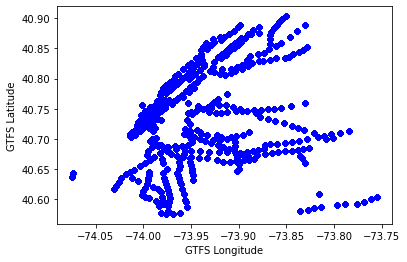

In [54]:
# Very basic plot of lat/long
turnstile_station.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude", alpha=0.1, color="blue")

### CC - This is the lat/long graph (stations as bubbles) and income as color
. Need to fix merge to get data at a unique station level
. Can make something more complex by adding map onto the graph

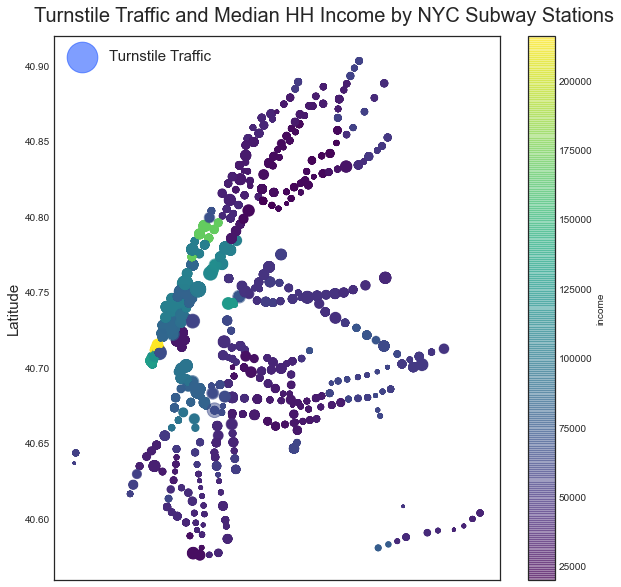

In [182]:
import plotly.graph_objects as go
from plotly.graph_objects import Layout
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

turnstile_station.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude",
    s=turnstile_station['People_per_hour']/5, label="Turnstile Traffic",
    c="income", cmap=plt.get_cmap("viridis"),
    colorbar=True, alpha=0.5, figsize=(10,10),
    
)
plt.legend(fontsize=15)
#plt.title('Pedestrian Traffic and Median HH Income by Subway Stations')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.figtext(.5,.9,'Turnstile Traffic and Median HH Income by NYC Subway Stations', fontsize=20, ha='center')

plt.style.use(['seaborn-bright'])
plt.style.use(['seaborn-white'])

plt.savefig("table1_traffic_inc.png")
plt.show()

## Top Stations by Income

In [64]:
station_level = turnstile_station.groupby(['STATION'])[['income','People_per_hour','GTFS Latitude','GTFS Longitude']].agg('mean').reset_index().sort_values(('income'),ascending=False)

In [65]:
station_level.sort_values(by=['income'],ascending=False)

,STATION,income,People_per_hour,GTFS Latitude,GTFS Longitude
184,CITY HALL,216037.0,37.381944,40.713282,-74.006978
375,WTC-CORTLANDT,216037.0,43.587518,40.711835,-74.012188
374,WORLD TRADE CTR,216037.0,84.791310,40.712603,-74.009551
179,CHAMBERS ST,216037.0,72.800787,40.713454,-74.008050
191,CORTLANDT ST,216037.0,46.617680,40.712603,-74.009552
...,...,...,...,...,...
328,RIT-MANHATTAN,NaN,56.264019,NaN,NaN
329,RIT-ROOSEVELT,NaN,42.828467,NaN,NaN
350,THIRTY ST,NaN,64.261364,NaN,NaN
351,THIRTY THIRD ST,NaN,107.283615,NaN,NaN


## Top 10 Stations by Income

In [66]:
print(station_level.nlargest(10,['income']))

             STATION         income  People_per_hour  GTFS Latitude  \
184        CITY HALL  216037.000000        37.381944      40.713282   
179      CHAMBERS ST  216037.000000        72.800787      40.713454   
191     CORTLANDT ST  216037.000000        46.617680      40.712603   
375    WTC-CORTLANDT  216037.000000        43.587518      40.711835   
374  WORLD TRADE CTR  216037.000000        84.791310      40.712603   
91     66 ST-LINCOLN  170630.000000        84.671036      40.773440   
310       PARK PLACE  148689.848671        49.336401      40.695699   
115            96 ST  143382.815571       132.716408      40.791865   
158    BOWLING GREEN  129574.000000        89.622168      40.704817   
245    HUNTERS PT AV  125871.000000        47.324388      40.742216   

     GTFS Longitude  
184      -74.006978  
179      -74.008050  
191      -74.009552  
375      -74.012188  
374      -74.009551  
91       -73.982209  
310      -73.986349  
115      -73.966619  
158      -74.014065 

### Remove stations clustered (same complex)
We know within the top 10 we have multiple stations WTC in the same complex. 
We can choose one station

In [67]:
# we know several of our top stations are connected. lets collapse / remove those (i.e. WTC, Etc.)
stations_rm_wtc = station_level[(station_level['STATION'] == ("CITY HALL")) |
                                (station_level['STATION']==("CHAMBERS ST")) |
                                (station_level['STATION']==("CORTLANDT ST")) | 
                                (station_level['STATION']==("WTC-CORTLANDT")) |
                                (station_level['STATION']==("HUNTERS PT AV")) |
                                (station_level['STATION']==("21 ST")) |
                                (station_level['STATION']==("WHITEHALL S-FRY")) |
                                (station_level['STATION']==("SOUTH FERRY")) 
                               ].index 

In [68]:
stations_rm = station_level.drop(stations_rm_wtc) 

In [69]:
stations_top10inc = stations_rm.nlargest(10,['income'])

In [70]:
stations_top10inc.head(20)

,STATION,income,People_per_hour,GTFS Latitude,GTFS Longitude
374,WORLD TRADE CTR,216037.000000,84.791310,40.712603,-74.009551
91,66 ST-LINCOLN,170630.000000,84.671036,40.773440,-73.982209
310,PARK PLACE,148689.848671,49.336401,40.695699,-73.986349
115,96 ST,143382.815571,132.716408,40.791865,-73.966619
158,BOWLING GREEN,129574.000000,89.622168,40.704817,-74.014065
361,VERNON-JACKSON,125871.000000,99.391827,40.742626,-73.953581
110,86 ST,123429.242033,97.065516,40.751550,-73.973749
327,RECTOR ST,119274.000000,45.097492,40.707356,-74.013547
365,WALL ST,119274.000000,74.825453,40.707225,-74.010616
93,68ST-HUNTER CO,115519.000000,94.453328,40.768141,-73.963870


## Print out list of top 10 stations by Income

In [172]:
# Table 1b
stations_top10inc.to_csv(r'table1b_top10inc_list.csv', index = False)

## Rescale the people per hour to make point larger

In [71]:
stations_top10inc['People_per_hour_scale'] = stations_top10inc['People_per_hour']*4

In [72]:
stations_top10inc.head()

,STATION,income,People_per_hour,GTFS Latitude,GTFS Longitude,People_per_hour_scale
374,WORLD TRADE CTR,216037.000000,84.791310,40.712603,-74.009551,339.165238
91,66 ST-LINCOLN,170630.000000,84.671036,40.773440,-73.982209,338.684145
310,PARK PLACE,148689.848671,49.336401,40.695699,-73.986349,197.345603
115,96 ST,143382.815571,132.716408,40.791865,-73.966619,530.865631
158,BOWLING GREEN,129574.000000,89.622168,40.704817,-74.014065,358.488671


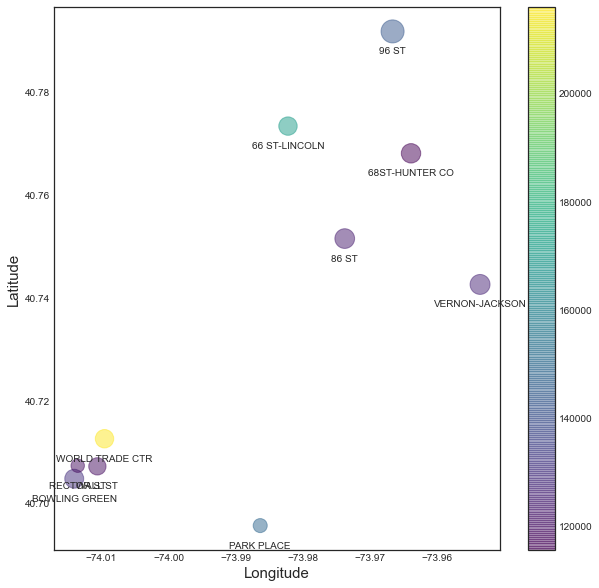

In [183]:
# Table 2c. Works but no scale
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

# Top 10 stations by income (1st pass - shows outliers)
y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour_scale'].tolist()
cm=stations_top10inc['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10,10))
#fig.suptitle('Top 10 Stations by Median HH Income',fontsize=25)

plt.scatter(x,y,
           c=cm,cmap="viridis",
           s=sm,
           alpha=0.5,     # Alpha of the dots
           linewidths=1
           )
plt.colorbar() 

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(0,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='center',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
#plt.legend(loc='upper center', bbox_to_anchor=(1,1), fancybox=True, ncol=5, labels=['income'])
#plt.colorbar(cm)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table2_top10_income.svg")
plt.show()

&ensp;&ensp;&ensp;&ensp;**6c. Graphs for tech (PLEASE SEE JOSHUA MAILMAN BANKS AND CHUCK CAO'S CODE)**

<br>

## 7. (CChan): Attempts to improve maps

In [106]:
import geopandas as gpd

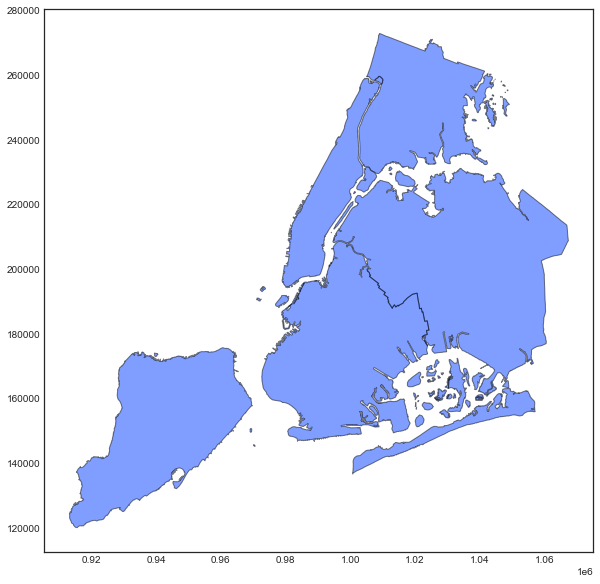

In [90]:
df = gpd.read_file(gpd.datasets.get_path('nybb'))
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [99]:
mh=df[df["BoroName"]=="Manhattan"]

In [100]:
mh.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."


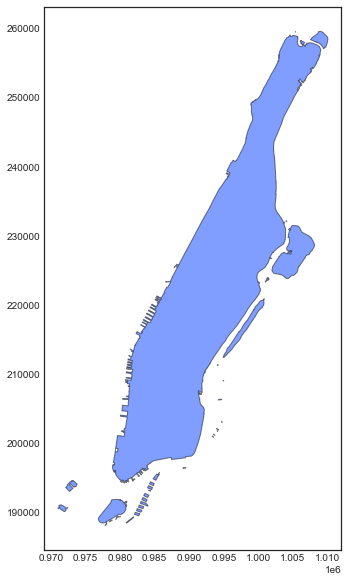

In [103]:
ax = mh.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [109]:
# import libraries
from shapely.geometry import Point, Polygon
#import matplotlib.pyplot as plt
#import street map
street_map = gpd.read_file('/Users/chrischan/Documents/Metis_proj1/pgms/Borough Boundaries/geo_export_2531085b-babd-4126-b357-82b63b5db2a1.shp')

In [115]:
# designate coordinate system
#crs = {'init':'espc:4326'}
crs=4326

In [116]:
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(turnstile_station['GTFS Longitude'], turnstile_station['GTFS Latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(turnstile_station,
                            crs = crs,
                            geometry = geometry)

In [117]:
geo_df.head()

,STATION,Datetime,Day_of_week,Day_num,Hour,Day_hour,People_per_hour,GTFS Latitude,GTFS Longitude,income,geometry
1,59 ST,2019-06-22 04:00:00,Saturday,5,4,5.166667,5.25,40.762593,-73.967612,112269.0,POINT (-73.96761 40.76259)
2,59 ST,2019-06-22 08:00:00,Saturday,5,8,5.333333,12.25,40.762593,-73.967612,112269.0,POINT (-73.96761 40.76259)
3,59 ST,2019-06-22 12:00:00,Saturday,5,12,5.500000,36.75,40.762593,-73.967612,112269.0,POINT (-73.96761 40.76259)
4,59 ST,2019-06-22 16:00:00,Saturday,5,16,5.666667,64.25,40.762593,-73.967612,112269.0,POINT (-73.96761 40.76259)
5,59 ST,2019-06-22 20:00:00,Saturday,5,20,5.833333,71.25,40.762593,-73.967612,112269.0,POINT (-73.96761 40.76259)


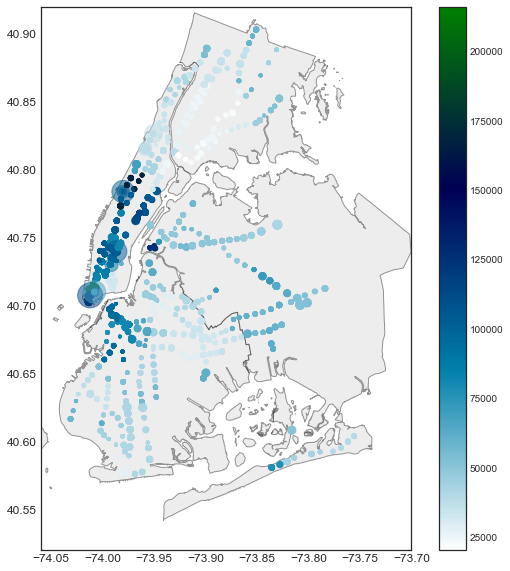

In [212]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(10,10))
# add .shp mapfile to axes

street_map.plot(ax=ax,
                alpha=0.4,
                color='lightgrey',
                edgecolor='k')

# add geodataframe to axes
# assign ioncme/subway variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize

geo_df.plot(column='income',
            ax=ax,
            alpha=0.5,
            legend=True,
            s=geo_df['People_per_hour']/15,
            #markersize=20,
            #colorbar=True,
            cmap=plt.get_cmap("ocean_r"),
            figsize=(10,10)
            )
# add title to graph
# set latitiude and longitude boundaries for map display
#plt.legend(prop={'size':8}
plt.xlim(-74.06,-73.70)
plt.ylim( 40.52,40.92)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)


plt.savefig("table1_traffic_inc_new.svg")

# show map
plt.show()

## Focus on manhattan top 10 stations

In [174]:
# zip x and y coordinates into single feature
geometry2 = [Point(xy) for xy in zip(stations_top10inc['GTFS Longitude'], stations_top10inc['GTFS Latitude'])]
# create GeoPandas dataframe
geo_df2 = gpd.GeoDataFrame(stations_top10inc,
                            crs = crs,
                            geometry = geometry2)

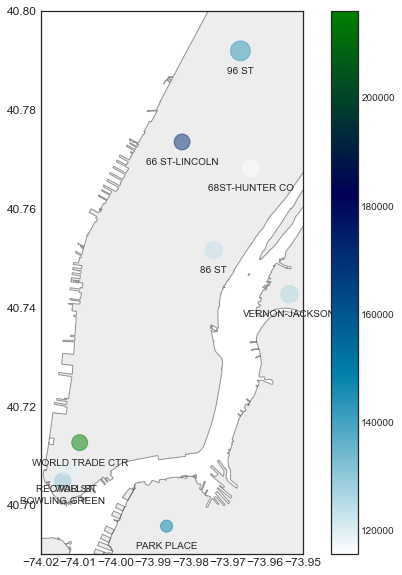

In [211]:
# Create lists for annotation: Top 10 stations by income (1st pass - shows outliers)
y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour_scale'].tolist()
cm=stations_top10inc['income'].tolist()

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(10,10))
# add .shp mapfile to axes

street_map.plot(ax=ax,
                alpha=0.4,
                color='lightgrey',
                edgecolor='k')

# add geodataframe to axes
# assign ioncme/subway variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize

geo_df2.plot(column='income',
            ax=ax,
            alpha=0.5,
            legend=True,
            s=geo_df2['People_per_hour']*3,
            #markersize=20,
            #colorbar=True,
            cmap=plt.get_cmap("ocean_r"),
            figsize=(10,10)
            )

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(0,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='center',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# add title to graph
# set latitiude and longitude boundaries for map display
plt.xlim(-74.02,-73.95)
plt.ylim( 40.69,40.80)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)



plt.savefig("table2_top10_inc_new.svg")
# show map
plt.show()

## 8. (CChan): Testing Code

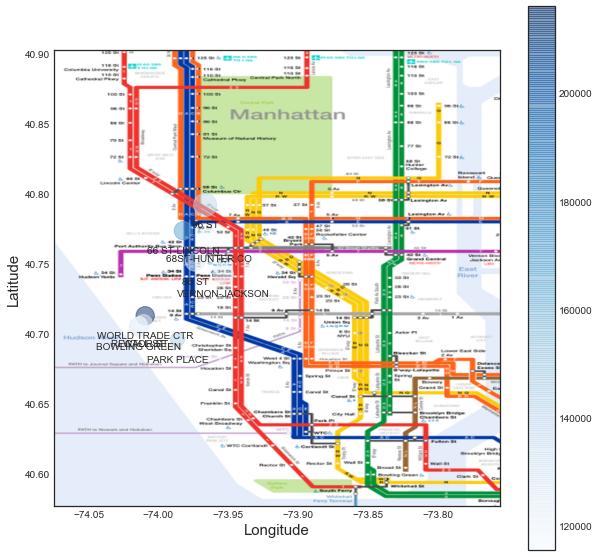

In [83]:
# Table 2c. Works but no scale
import plotly.graph_objects as go
from plotly.graph_objects import Layout
from imread import imread

layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

img=imread('mh1.png')

# Top 10 stations by income (1st pass - shows outliers)
y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour_scale'].tolist()
cm=stations_top10inc['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10,10))
#fig.suptitle('Top 10 Stations by Median HH Income',fontsize=25)

plt.imshow(img,zorder=0,
           extent=[turnstile_station['GTFS Longitude'].min(),
                   turnstile_station['GTFS Longitude'].max(),
                   turnstile_station['GTFS Latitude'].min(),
                   turnstile_station['GTFS Latitude'].max()])

plt.scatter(x,y,
           c=cm,cmap="Blues",
           s=sm,
           alpha=0.5,     # Alpha of the dots
           linewidths=1
           )
plt.colorbar() 

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(0,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='center',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
#plt.legend(loc='upper center', bbox_to_anchor=(1,1), fancybox=True, ncol=5, labels=['income'])
#plt.colorbar(cm)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table2_top10_income.svg")
plt.show()

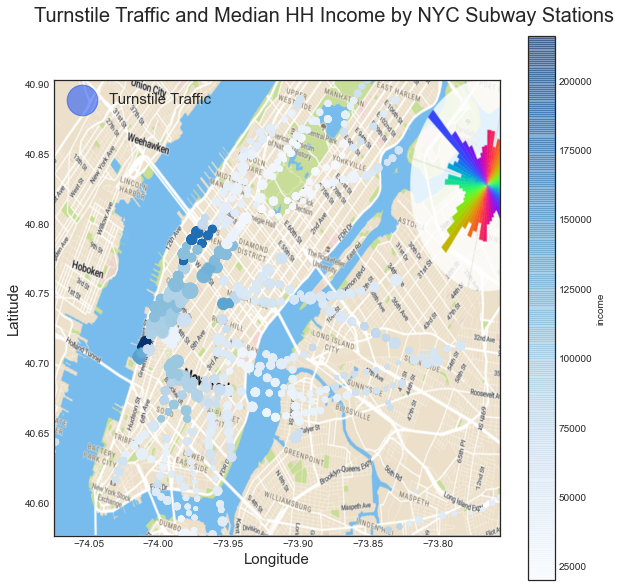

In [82]:
import plotly.graph_objects as go
from plotly.graph_objects import Layout
from imread import imread
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

img=imread('Picture3.png')

plt.imshow(img,zorder=0,
           extent=[turnstile_station['GTFS Longitude'].min(),
                   turnstile_station['GTFS Longitude'].max(),
                   turnstile_station['GTFS Latitude'].min(),
                   turnstile_station['GTFS Latitude'].max()])

ax=plt.gca()
turnstile_station.plot(kind="scatter",
                       x="GTFS Longitude",
                       y="GTFS Latitude",
                       s=turnstile_station['People_per_hour']/5,
                       label="Turnstile Traffic",
                       c="income", 
                       cmap=plt.get_cmap("Blues"),
                       ax=ax,
                       colorbar=True, alpha=0.5, figsize=(10,10),
    
)
plt.legend(fontsize=15)
#plt.title('Pedestrian Traffic and Median HH Income by Subway Stations')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.figtext(.5,.9,'Turnstile Traffic and Median HH Income by NYC Subway Stations', fontsize=20, ha='center')

plt.style.use(['seaborn-bright'])
plt.style.use(['seaborn-white'])

# plt.savefig("table1_traffic_inc.png")
plt.show()

### Attempts to test on various images to overlay points

In [ ]:
plt.figure(figsize=(10,10))
img=imread('newyork.png')

plt.imshow(img,zorder=0,
           
           extent=[housing['longitude'].min(),
                   housing['longitude'].max(),
                   housing['latitude'].min(),
                   housing['latitude'].max()])
ax = plt.gca()
housing.plot(x='longitude', 
             y='latitude', 
             kind='scatter', 
             alpha=0.4, 
             s= housing['population']/100, label='population', ax=ax,
             c= 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, 
             zorder=5)
plt.legend()
plt.show()

In [ ]:
## Table 2. Working graph of top 10 - no point labels
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')
stations_top10inc.plot(kind="scatter", 
                       x="GTFS Longitude",
                       y="GTFS Latitude",
                       s=stations_top10inc['People_per_hour']*10, 
                       label="Pedestrian Traffic",
                       c="income", cmap=plt.get_cmap("jet"),
                       colorbar=True, alpha=0.5, figsize=(10,10),
    
)
plt.legend(fontsize=15)
#plt.title('Pedestrian Traffic and Median HH Income by Subway Stations')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.figtext(.5,.9,'Turnstile Traffic and Top 10 Median HH Income by NYC Subway Stations', fontsize=20, ha='center')
plt.savefig("table2_traffic_inc.png")
plt.show()

In [ ]:
## Table 2b. Working graph of top 10 - no point labels
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour'].tolist()
cm=stations_top10inc['income'].tolist()


stations_top10inc.plot(kind="scatter", 
                       x="GTFS Longitude",
                       y="GTFS Latitude",
                       s=stations_top10inc['People_per_hour']*10, 
                       label="Pedestrian Traffic",
                       c="income", cmap=plt.get_cmap("jet"),
                       colorbar=True, alpha=0.5, figsize=(10,10),
    
)
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
            xy=(x_pos, y_pos), # Position of the corresponding point
            xytext=(-10,10),     # Offset text by 7 points to the right
            textcoords='offset points', # tell it to use offset points
            ha='left',         # Horizontally aligned to the left
            va='center',
            fontsize=10)   
    
plt.legend(fontsize=15)
#plt.title('Pedestrian Traffic and Median HH Income by Subway Stations')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.figtext(.5,.9,'Turnstile Traffic and Top 10 Median HH Income by NYC Subway Stations', fontsize=20, ha='center')
plt.savefig("table2_traffic_inc.png")
plt.show()  


In [ ]:
# Table 2c. Works but no scale
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

# Top 10 stations by income (1st pass - shows outliers)
y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour_scale'].tolist()
cm=stations_top10inc['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(7,7))
fig.suptitle('Top 10 Stations by Median HH Income',fontsize=20)

ax.scatter(x, y,
           c=cm ,  # Color of the dots (blue)
           s=sm ,         # Size of the dots (50)
           alpha=0.5,     # Alpha of the dots
           linewidths=1,                      
           cmap=plt.get_cmap("rainbow")
          )  # Size of edge around the dots

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(0,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='center',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
#plt.legend(loc='upper center', bbox_to_anchor=(1,1), fancybox=True, ncol=5, labels=['income'])
#plt.colorbar(cm)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table2_top10_income.svg")
plt.show()

In [ ]:
# If we had a classification - we would remove lincoln hunters and 96th st

#stations_top10cluster = station_level.nlargest(10,['income'])
stations_top10index = stations_top10inc[(stations_top10inc['STATION'] == ("HUNTERS PT AV")) |
                                        (stations_top10inc['STATION']==("96 ST")) |
                                        (stations_top10inc['STATION']==("66 ST-LINCOLN")) | 
                                        (stations_top10inc['STATION']==("PARK PLACE"))].index 


In [ ]:
stations_top10_cluster = stations_top10inc.drop(stations_top10index) 

In [ ]:
stations_top10_cluster.head(10)

In [ ]:
# Top 7 stations by income (2ND pass - removes outliers)

y = stations_top10_cluster["GTFS Latitude"].unique().tolist()
x = stations_top10_cluster["GTFS Longitude"].unique().tolist()
labels = stations_top10_cluster['STATION'].unique().tolist()
sm=stations_top10_cluster['People_per_hour'].unique().tolist()
cm=stations_top10_cluster['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10,10))
fig.suptitle('Top Subway Station Cluster by Median HH Income',fontsize=20)

# Plot the scatter points
ax.scatter(x, y,
           c=cm ,  # Color of the dots (blue)
           s=sm ,         # Size of the dots (50)
           alpha=0.5,     # Alpha of the dots
           linewidths=1,
           cmap=plt.get_cmap("rainbow")
          )  # Size of edge around the dots

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(-10,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table3_top_income_cluster.svg")
plt.show()

In [ ]:
# PLACEHOLDER 

y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour'].tolist()
cm=stations_top10inc['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10,10))
fig.suptitle('Top 10 Stations by Median HH Income',fontsize=20)

# Plot the scatter points
ax.scatter(x, y,
           c=cm ,  # Color of the dots (blue)
           s=sm ,         # Size of the dots (50)
           alpha=0.5,     # Alpha of the dots
           linewidths=1,                      
           cmap=plt.get_cmap("rainbow")
          )  # Size of edge around the dots

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(-10,10),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
ax.legend(cm)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table2_top10_income.svg")
plt.show()

## ------------ CC - END income geo graphs ------------